# Определение рыночной стоимости автомобиля

В моем распоряжении исторические данные с техническими характеристиками, комплектациями и ценами автомобилей. Необходимо построить и сравнить несколько моделей для определения стоимости автомобиля.

### Содержание:

#### 1) <a href='#Preprocesing'> Изучение данных и предобработка</a>
#### 2) <a href='#Feature preprocessing'> Подготовка признаков к обучению</a>
#### 3) <a href='#Model training'> Обучение моделей</a>

- <a href='#SKlearn'> SKlearn</a>
- <a href='#LightGBM'> LightGBM</a>
- <a href='#XGBoost'> XGBoost</a>
- <a href='#Catboost'> Catboost</a>

#### 4) <a href='#Conclusion'> Вывод</a>

<a id='Preprocesing'></a>
## Изучение данных и предобработка

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor, BayesianRidge, LassoLars
from sklearn.linear_model import ARDRegression, PassiveAggressiveRegressor, TheilSenRegressor, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

import random
import time
import warnings

In [2]:
autos = pd.read_csv('C:\\Users\\yansa\\YP_Projects\\YP_DataSets\\SP10\\autos.csv')

In [3]:
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Удаляю ненужные для дальнейшей работы столбцы:

In [6]:
autos = autos.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

In [7]:
autos = autos[autos['Price'] != 0]
autos = autos[(autos['RegistrationYear'] > 1900) & (autos['RegistrationYear'] <= 2020)]

In [8]:
autos.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


Незаполненные значения меняю на unknown:

In [9]:
autos[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']] = \
autos[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']].fillna('unk')

In [10]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343458 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              343458 non-null  int64 
 1   VehicleType        343458 non-null  object
 2   RegistrationYear   343458 non-null  int64 
 3   Gearbox            343458 non-null  object
 4   Power              343458 non-null  int64 
 5   Model              343458 non-null  object
 6   Kilometer          343458 non-null  int64 
 7   RegistrationMonth  343458 non-null  int64 
 8   FuelType           343458 non-null  object
 9   Brand              343458 non-null  object
 10  NotRepaired        343458 non-null  object
dtypes: int64(5), object(6)
memory usage: 31.4+ MB


Проверяю на выбросы и аномалии:

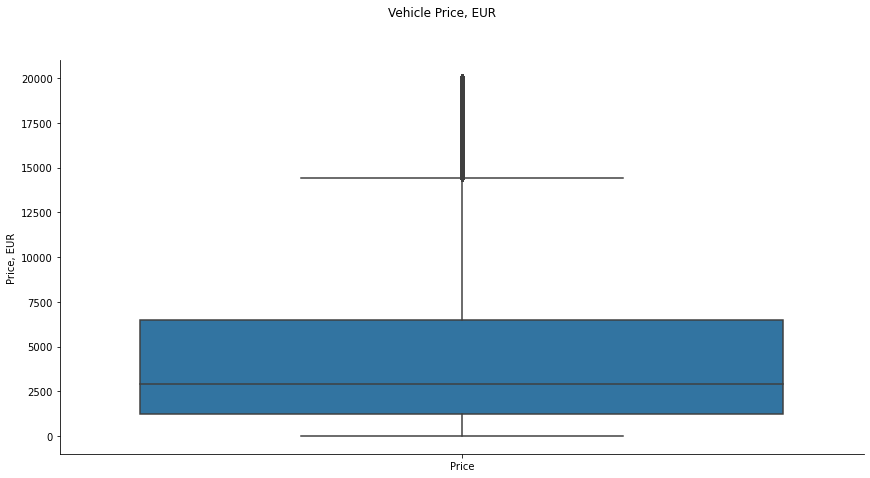

In [11]:
plot = sns.catplot(data=pd.DataFrame(autos['Price']), kind='box', height=6, 
                    aspect=2, legend_out=False)
plot.set_axis_labels(y_var='Price, EUR')
plot.set
plot.fig.suptitle('Vehicle Price, EUR', y=1.1);

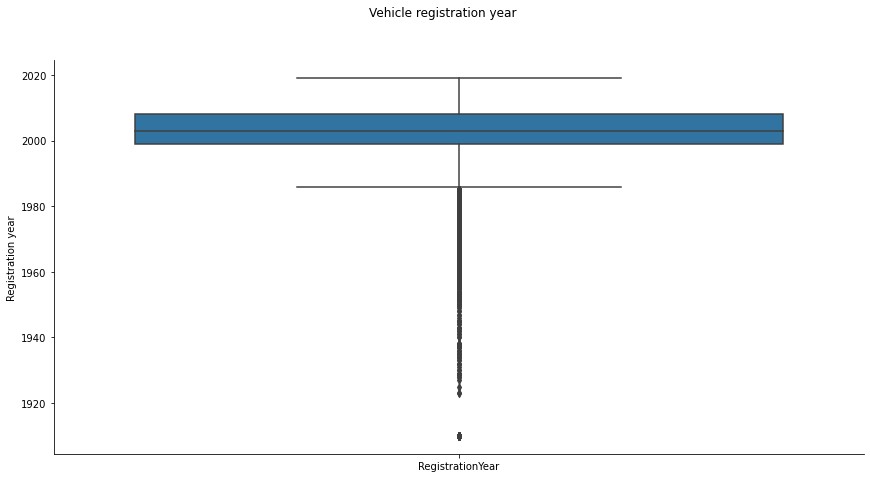

In [12]:
plot = sns.catplot(data=pd.DataFrame(autos['RegistrationYear']), kind='box', height=6, 
                    aspect=2, legend_out=False)
plot.set_axis_labels(y_var='Registration year')
plot.set
plot.fig.suptitle('Vehicle registration year', y=1.1);

In [13]:
iqr = autos['RegistrationYear'].describe()[6] - autos['RegistrationYear'].describe()[4]
cutting_point = autos['RegistrationYear'].describe()[4] - 3 * iqr
cutting_point

1972.0

In [14]:
autos[autos['RegistrationYear'] < cutting_point].describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000
mean,7561.169329,1962.260064,70.719489,77408.945687,4.163578
std,5855.645462,12.739199,414.861284,52152.934380,3.539521
min,1.000000,1910.000000,0.000000,5000.000000,0.000000
25%,2500.000000,1960.000000,0.000000,30000.000000,1.000000
50%,6500.000000,1966.000000,34.000000,80000.000000,4.000000
75%,12000.000000,1970.000000,76.000000,125000.000000,7.000000
max,20000.000000,1971.000000,16051.000000,150000.000000,12.000000


Значений с нетипичными для датасета годами не так много и по ним очень большой разброс цен, поэтому их удаляю.

In [15]:
autos = autos[autos['RegistrationYear'] >= cutting_point]

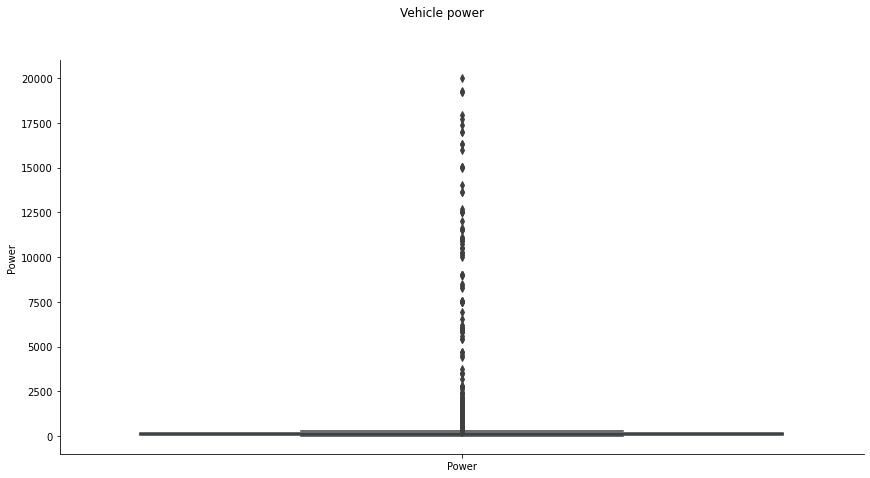

In [16]:
plot = sns.catplot(data=pd.DataFrame(autos['Power']), kind='box', height=6, 
                    aspect=2, legend_out=False)
plot.set_axis_labels(y_var='Power')
plot.set
plot.fig.suptitle('Vehicle power', y=1.1);

Заменю аномальные значения на 0 (неизвестно)

In [17]:
iqr = autos['Power'].describe()[6] - autos['Power'].describe()[4]
cutting_point = autos['Power'].describe()[6] + 3 * iqr
cutting_point

365.0

In [18]:
autos[autos['Power'] > cutting_point].count()['Power']

965

In [19]:
autos['Power'] = autos['Power'].map(lambda x: x if x <= cutting_point else 0)

In [20]:
autos[autos['Power'] > cutting_point].count()['Power']

0

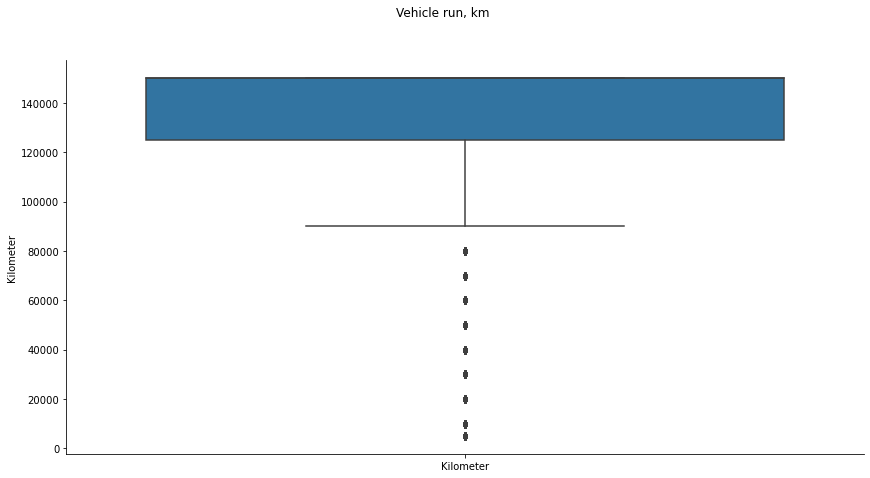

In [21]:
plot = sns.catplot(data=pd.DataFrame(autos['Kilometer']), kind='box', height=6, 
                    aspect=2, legend_out=False)
plot.set_axis_labels(y_var='Kilometer')
plot.set
plot.fig.suptitle('Vehicle run, km', y=1.1);

In [22]:
autos.reset_index(drop=True, inplace=True)

In [23]:
autos

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,unk,1993,manual,0,golf,150000,0,petrol,volkswagen,unk
1,18300,coupe,2011,manual,190,unk,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unk
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
341888,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no
341889,2200,unk,2005,unk,0,unk,20000,1,unk,sonstige_autos,unk
341890,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
341891,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


Удаляю дубликаты:

In [24]:
print('Кол-во дубликатов:', autos[autos.duplicated()]['Price'].count())
print(autos.shape[0])
autos.drop_duplicates(inplace=True, ignore_index=True)
print(autos.shape[0])

Кол-во дубликатов: 26120
341893
315773


In [25]:
autos.nunique()

Price                3721
VehicleType             9
RegistrationYear       48
Gearbox                 3
Power                 358
Model                 251
Kilometer              13
RegistrationMonth      13
FuelType                8
Brand                  40
NotRepaired             3
dtype: int64

In [26]:
autos.pivot_table(index='RegistrationMonth', aggfunc='count')

,Brand,FuelType,Gearbox,Kilometer,Model,NotRepaired,Power,Price,RegistrationYear,VehicleType
RegistrationMonth,,,,,,,,,,
0,30675,30675,30675,30675,30675,30675,30675,30675,30675,30675
1,20794,20794,20794,20794,20794,20794,20794,20794,20794,20794
2,19153,19153,19153,19153,19153,19153,19153,19153,19153,19153
3,31040,31040,31040,31040,31040,31040,31040,31040,31040,31040
4,26616,26616,26616,26616,26616,26616,26616,26616,26616,26616
5,26230,26230,26230,26230,26230,26230,26230,26230,26230,26230
6,28316,28316,28316,28316,28316,28316,28316,28316,28316,28316
7,24523,24523,24523,24523,24523,24523,24523,24523,24523,24523
8,20286,20286,20286,20286,20286,20286,20286,20286,20286,20286


In [27]:
def random_digit(row):
    month = row['RegistrationMonth']
    if month == 0:
        return random.randint(1, 12)
    else:
        return month

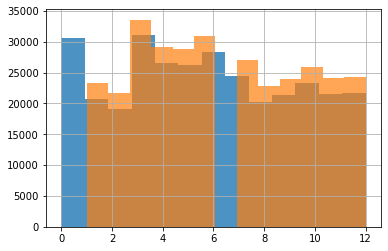

In [28]:
autos['RegistrationMonth'].hist(alpha=0.8, bins = 13);
autos['RegistrationMonth'] = autos.apply(random_digit, axis=1)
autos['RegistrationMonth'].hist(alpha=0.7, bins = 13);

In [29]:
autos['RegistrationMonth'].unique()

array([ 7,  5,  8,  6, 10, 11, 12,  2,  3,  9,  1,  4], dtype=int64)

In [30]:
my_list = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
for i in my_list:
    display(autos[i].unique())

array(['unk', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

array(['manual', 'auto', 'unk'], dtype=object)

array(['golf', 'unk', 'grand', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'other', 'c4', 'civic',
       'transporter', 'punto', 'e_klasse', 'clio', 'kadett', 'kangoo',
       'one', 'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8',
       'jetta', 'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156',
       'escort', 'forester', 'xc_reihe', 'scenic', 'a4', 'ka', 'a1',
       'insignia', 'combo', 'focus', 'tt', 'corsa', 'a6', 'jazz', 'omega',
       'slk', '7er', '80', '147', '100', 'z_reihe', 'sportage', 'sorento',
       'v40', 'ibiza', 'mustang', 'eos', 'touran', 'getz', 'a3', 'almera',
       'megane', 'lupo', 'r19', 'zafira', 'caddy', 'mondeo', 'cordoba',
       'colt', 'impreza', 'vectra', 'berlingo', 'tiguan', 'i_reihe',
       'espace', 'sharan', '6_reihe', 'panda', 'up', 'seicento', 'ceed',
       '5_reihe', 'yeti', 'octavia', 'mii', 'rx_reihe', '6er', 'modus',
   

array(['petrol', 'gasoline', 'unk', 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'chrysler', 'jaguar', 'daewoo', 'porsche',
       'rover', 'saab', 'land_rover', 'lada'], dtype=object)

array(['unk', 'yes', 'no'], dtype=object)

Данные предобработаны, готовы к подготовке для машинного обучения.

<a id='Feature preprocessing'></a>
## Подготовка признаков к обучению

In [31]:
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
quantitive = ['Power', 'RegistrationYear', 'Kilometer', 'RegistrationMonth']

In [32]:
autos.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,unk,1993,manual,0,golf,150000,7,petrol,volkswagen,unk
1,18300,coupe,2011,manual,190,unk,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unk
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


Применим OrdinalEncoder к колонкам с категориальными признаками.

In [33]:
encoder = OrdinalEncoder()
encoder.fit(autos[categorical])
autos[categorical] = pd.DataFrame(encoder.transform(autos[categorical]), 
                                                            columns=autos[categorical].columns).astype('int64')

autos.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,7,1993,1,0,116,150000,7,6,38,1
1,18300,2,2011,1,190,228,125000,5,2,1,2
2,9800,6,2004,0,163,117,125000,8,2,14,1
3,1500,5,2001,1,75,116,150000,6,6,38,0
4,3600,5,2008,1,69,101,90000,7,2,31,0


Подготовлю два датесета: в первом категориальные признаки будут закодированы методом ordinal (autos_ord), а во втором one-hot-encoding (autos_ohe).

In [34]:
autos_ord = autos.copy()
autos_ohe = autos.copy()

In [35]:
autos_ohe = pd.get_dummies(data=autos_ohe, columns=categorical, drop_first=True)

Разбиваю на обучающую и тренировочную выборки.

In [36]:
x_autos_ord = autos_ord.drop('Price', axis=1)
y_autos_ord = autos_ord['Price']
x_autos_ohe = autos_ohe.drop('Price', axis=1)
y_autos_ohe = autos_ohe['Price']

In [37]:
x_autos_ord_train, x_autos_ord_test, y_autos_ord_train, y_autos_ord_test = train_test_split(x_autos_ord, y_autos_ord, 
                                                                                            random_state=12345)
x_autos_ord_train.shape, x_autos_ord_test.shape, y_autos_ord_train.shape, y_autos_ord_test.shape

((236829, 10), (78944, 10), (236829,), (78944,))

In [38]:
x_autos_ohe_train, x_autos_ohe_test, y_autos_ohe_train, y_autos_ohe_test = train_test_split(x_autos_ohe, y_autos_ohe, 
                                                                                            random_state=12345)
x_autos_ohe_train.shape, x_autos_ohe_test.shape, y_autos_ohe_train.shape, y_autos_ohe_test.shape

((236829, 312), (78944, 312), (236829,), (78944,))

 Провожу масштабирование.

In [39]:
scaler_ord = StandardScaler()

warnings.filterwarnings(action='ignore')

x_autos_ord_train.loc[:, quantitive] = scaler_ord.fit_transform(
    x_autos_ord_train.loc[:, quantitive])

x_autos_ord_test.loc[:, quantitive] = scaler_ord.transform(x_autos_ord_test.loc[:, quantitive])

warnings.filterwarnings(action='default')

display(x_autos_ord_train[quantitive].head())
display(x_autos_ord_test[quantitive].head())

,Power,RegistrationYear,Kilometer,RegistrationMonth
239546,0.039144,0.243306,-1.032193,0.181601
26324,0.918652,0.535008,-0.094084,-0.413670
128440,0.250877,0.826710,-0.094084,-0.711305
40831,-0.840364,-2.382012,-0.764162,0.181601
170442,0.788355,0.243306,0.575995,-0.711305


,Power,RegistrationYear,Kilometer,RegistrationMonth
237063,-0.270313,-1.361055,0.575995,1.669777
10226,-1.736160,-0.340098,0.575995,-1.008941
201397,-1.736160,1.847667,0.575995,1.074507
189228,-1.736160,-0.194247,-0.764162,-1.604211
110596,-0.693780,-0.194247,0.575995,0.479236


In [40]:
scaler_ohe = StandardScaler()

warnings.filterwarnings(action='ignore')

x_autos_ohe_train.loc[:, quantitive] = scaler_ohe.fit_transform(
    x_autos_ohe_train.loc[:, quantitive])

x_autos_ohe_test.loc[:, quantitive] = scaler_ohe.transform(x_autos_ohe_test.loc[:, quantitive])

warnings.filterwarnings(action='default')

display(x_autos_ohe_train[quantitive].head())
display(x_autos_ohe_test[quantitive].head())

,Power,RegistrationYear,Kilometer,RegistrationMonth
239546,0.039144,0.243306,-1.032193,0.181601
26324,0.918652,0.535008,-0.094084,-0.413670
128440,0.250877,0.826710,-0.094084,-0.711305
40831,-0.840364,-2.382012,-0.764162,0.181601
170442,0.788355,0.243306,0.575995,-0.711305


,Power,RegistrationYear,Kilometer,RegistrationMonth
237063,-0.270313,-1.361055,0.575995,1.669777
10226,-1.736160,-0.340098,0.575995,-1.008941
201397,-1.736160,1.847667,0.575995,1.074507
189228,-1.736160,-0.194247,-0.764162,-1.604211
110596,-0.693780,-0.194247,0.575995,0.479236


<a id='Model training'></a>
## Обучение моделей

<a id='SKlearn'></a>
### SKlearn

Добавим регрессионные модели в списки:

In [41]:
linear = [LinearRegression(normalize=True), BayesianRidge(normalize=True), LassoLars(normalize=False),
          PassiveAggressiveRegressor(random_state=12345)]
trees = [DecisionTreeRegressor(random_state=12345, max_depth=10)]
gb = [GradientBoostingRegressor(random_state=12345, n_estimators=1200, learning_rate=0.25)]

Обучаю и собираю результаты работы моделей в единый датафрейм:

In [42]:
results = pd.DataFrame({'Regressor' : [], 'CV RMSE score' : [], 'Train RMSE score' : [], 'Test RMSE score' : [], 
                        'Learning Time' : [], 'Prediction Time' : []})

In [43]:
def learn_models(models_list, x_train, y_train, x_test, y_test, params={}, model='default', regr_name='', n_jobs=-1):

    for i in models_list:
        regr_gs = GridSearchCV(i, params, cv=5, scoring='neg_root_mean_squared_error')
        if model == 'default':
            regr_gs.fit(x_train,y_train)
        if model == 'catboost':
            regr_gs.fit(x_train,y_train, cat_features=categorical)
        elif model == 'lgb':
            regr_gs.fit(x_train,y_train, categorical_feature=categorical)
        else:
            regr_gs.fit(x_train,y_train)
            
        cv_score = regr_gs.best_score_
        
        regr = regr_gs.best_estimator_
        start_learning = time.time()
        if model == 'default':
            regr.fit(x_train,y_train)
        if model == 'catboost':
            regr.fit(x_train,y_train, cat_features=categorical)
        elif model == 'lgb':
            regr.fit(x_train,y_train, categorical_feature=categorical)
        else:
            regr.fit(x_train,y_train)
        
        end_learning = time.time()
        duration_learning = end_learning - start_learning

        train_rmse_score = mean_squared_error(y_train, regr.predict(x_train), squared=False)

        start_prediction = time.time()
        test_rmse_score = mean_squared_error(y_test, regr.predict(x_test), squared=False)
        end_prediction = time.time()
        duration_prediction = end_prediction - start_prediction
        
        if regr_name == '':
            name = str(i).split(sep='(')[0]
        else:
            name = regr_name

        globals()['results'] = globals()['results'].append({
            'Regressor' : name, 'CV RMSE score' : round(cv_score, 2), 'Train RMSE score' : round(train_rmse_score, 2), 
            'Test RMSE score' : round(test_rmse_score, 2), 'Learning Time' :  round(duration_learning, 2), 
            'Prediction Time' : round(duration_prediction, 2)}, ignore_index=True)

In [49]:
learn_models(linear, x_autos_ohe_train, y_autos_ohe_train, x_autos_ohe_test, y_autos_ohe_test)

In [50]:
learn_models(trees, x_autos_ord_train, y_autos_ord_train, x_autos_ord_test, y_autos_ord_test)

In [51]:
learn_models(gb, x_autos_ord_train, y_autos_ord_train, x_autos_ord_test, y_autos_ord_test, 
             regr_name='GradientBoostingRegressor')

In [52]:
results

,Regressor,CV RMSE score,Train RMSE score,Test RMSE score,Learning Time,Prediction Time
0,LinearRegression,-1.871405e+15,2649.10,2645.87,12.68,0.14
1,BayesianRidge,-2.653960e+03,2649.12,2645.92,23.97,0.15
2,LassoLars,-2.686190e+03,2683.45,2679.09,2.61,0.15
3,PassiveAggressiveRegressor,-2.752280e+03,2749.67,2744.17,80.18,0.15
4,DecisionTreeRegressor,-2.053420e+03,1947.51,2019.18,1.18,0.01
5,GradientBoostingRegressor,-1.686180e+03,1613.36,1664.63,613.97,1.42


<a id='LightGBM'></a>
### LightGBM

In [53]:
lgb_regr = lgb.LGBMRegressor(n_estimators=1200, objective='root_mean_squared_error')
lgb_params = {'learning_rate': [0.1, 0.25]}

In [54]:
learn_models([lgb_regr], x_autos_ord_train, y_autos_ord_train, x_autos_ord_test, y_autos_ord_test, 
             params=lgb_params, regr_name='LGBMRegressor (ordinal)', n_jobs=1)

In [55]:
learn_models([lgb_regr], x_autos_ohe_train, y_autos_ohe_train, x_autos_ohe_test, y_autos_ohe_test, 
             params=lgb_params, regr_name='LGBMRegressor (ohe)', n_jobs=1)

In [56]:
warnings.filterwarnings(action='ignore')
learn_models([lgb_regr], x_autos_ord_train, y_autos_ord_train, x_autos_ord_test, y_autos_ord_test, 
             params=lgb_params, model='lgb', regr_name='LGBMRegressor (ordinal specified)', n_jobs=1)
warnings.filterwarnings(action='default')

In [57]:
results

,Regressor,CV RMSE score,Train RMSE score,Test RMSE score,Learning Time,Prediction Time
0,LinearRegression,-1.871405e+15,2649.10,2645.87,12.68,0.14
1,BayesianRidge,-2.653960e+03,2649.12,2645.92,23.97,0.15
2,LassoLars,-2.686190e+03,2683.45,2679.09,2.61,0.15
3,PassiveAggressiveRegressor,-2.752280e+03,2749.67,2744.17,80.18,0.15
4,DecisionTreeRegressor,-2.053420e+03,1947.51,2019.18,1.18,0.01
5,GradientBoostingRegressor,-1.686180e+03,1613.36,1664.63,613.97,1.42
6,LGBMRegressor (ordinal),-1.618910e+03,1411.62,1596.68,18.76,2.44
7,LGBMRegressor (ohe),-1.613430e+03,1458.93,1596.70,21.49,2.60
8,LGBMRegressor (ordinal specified),-1.598350e+03,1355.91,1576.00,8.44,1.88


<a id='XGBoost'></a>
### XGBoost

In [58]:
xgb_regr = xgb.XGBRegressor(learning_rate=0.1, n_estimators=1200)

In [59]:
learn_models([xgb_regr], x_autos_ord_train, y_autos_ord_train, x_autos_ord_test, y_autos_ord_test, 
             regr_name='XGBRegressor')

In [60]:
results

,Regressor,CV RMSE score,Train RMSE score,Test RMSE score,Learning Time,Prediction Time
0,LinearRegression,-1.871405e+15,2649.10,2645.87,12.68,0.14
1,BayesianRidge,-2.653960e+03,2649.12,2645.92,23.97,0.15
2,LassoLars,-2.686190e+03,2683.45,2679.09,2.61,0.15
3,PassiveAggressiveRegressor,-2.752280e+03,2749.67,2744.17,80.18,0.15
4,DecisionTreeRegressor,-2.053420e+03,1947.51,2019.18,1.18,0.01
5,GradientBoostingRegressor,-1.686180e+03,1613.36,1664.63,613.97,1.42
6,LGBMRegressor (ordinal),-1.618910e+03,1411.62,1596.68,18.76,2.44
7,LGBMRegressor (ohe),-1.613430e+03,1458.93,1596.70,21.49,2.60
8,LGBMRegressor (ordinal specified),-1.598350e+03,1355.91,1576.00,8.44,1.88
9,XGBRegressor,-1.616240e+03,1363.56,1596.54,131.70,2.07


<a id='Catboost'></a>
### CatBoost

In [61]:
cat_regr = CatBoostRegressor(iterations=1200, learning_rate=0.25, verbose=False)

In [62]:
learn_models([cat_regr], x_autos_ord_train, y_autos_ord_train, x_autos_ord_test, y_autos_ord_test, 
             regr_name='CatBoostRegressor (ordinal)')

In [63]:
learn_models([cat_regr], x_autos_ohe_train, y_autos_ohe_train, x_autos_ohe_test, y_autos_ohe_test, 
             regr_name='CatBoostRegressor (ohe)')

In [64]:
learn_models([cat_regr], x_autos_ord_train, y_autos_ord_train, x_autos_ord_test, y_autos_ord_test, model='catboost', 
             regr_name='CatBoostRegressor (ordinal specified)')

In [65]:
results

,Regressor,CV RMSE score,Train RMSE score,Test RMSE score,Learning Time,Prediction Time
0,LinearRegression,-1.871405e+15,2649.10,2645.87,12.68,0.14
1,BayesianRidge,-2.653960e+03,2649.12,2645.92,23.97,0.15
2,LassoLars,-2.686190e+03,2683.45,2679.09,2.61,0.15
3,PassiveAggressiveRegressor,-2.752280e+03,2749.67,2744.17,80.18,0.15
4,DecisionTreeRegressor,-2.053420e+03,1947.51,2019.18,1.18,0.01
5,GradientBoostingRegressor,-1.686180e+03,1613.36,1664.63,613.97,1.42
6,LGBMRegressor (ordinal),-1.618910e+03,1411.62,1596.68,18.76,2.44
7,LGBMRegressor (ohe),-1.613430e+03,1458.93,1596.70,21.49,2.60
8,LGBMRegressor (ordinal specified),-1.598350e+03,1355.91,1576.00,8.44,1.88
9,XGBRegressor,-1.616240e+03,1363.56,1596.54,131.70,2.07


<a id='Conclusion'></a>
## Вывод

In [66]:
results.sort_values('Test RMSE score', ascending=True)

,Regressor,CV RMSE score,Train RMSE score,Test RMSE score,Learning Time,Prediction Time
8,LGBMRegressor (ordinal specified),-1.598350e+03,1355.91,1576.00,8.44,1.88
9,XGBRegressor,-1.616240e+03,1363.56,1596.54,131.70,2.07
6,LGBMRegressor (ordinal),-1.618910e+03,1411.62,1596.68,18.76,2.44
10,CatBoostRegressor (ordinal),-1.629110e+03,1455.57,1609.56,53.87,0.03
7,LGBMRegressor (ohe),-1.613430e+03,1458.93,1596.70,21.49,2.60
11,CatBoostRegressor (ohe),-1.616100e+03,1462.14,1597.41,58.72,0.08
12,CatBoostRegressor (ordinal specified),-1.625770e+03,1496.66,1614.60,223.94,0.49
5,GradientBoostingRegressor,-1.686180e+03,1613.36,1664.63,613.97,1.42
4,DecisionTreeRegressor,-2.053420e+03,1947.51,2019.18,1.18,0.01
0,LinearRegression,-1.871405e+15,2649.10,2645.87,12.68,0.14


Лучший результат среди моделей использующих градиентный бустинг, как по метрике RMSE, так и по времени обучения модели показал LightGBMRegressor.